<p><font size="6"><b>Stacking of raster data</b></font></p>


> *DS Python for GIS and Geoscience*  
> *October, 2022*
>
> *© 2022, Joris Van den Bossche and Stijn Van Hoey. Licensed under [CC BY 4.0 Creative Commons](http://creativecommons.org/licenses/by/4.0/)*

---

In [1]:
import shutil
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xarray as xr

## Introduction

Geospatial time series data is often stored as multiple individual files. For example, remote sensing data or geoscience model output are typically organized with each time step (or band) in a separate file. Handling all these indidivudal files is culbersome and workflows to combine these files into a single `xarray.Dataset` or `xarray.DataArray` prior to the analysis are required. 

In this notebook, we will explore some ways to combine indidivual files into a single data product ready for analysis.

## Load multiple files into a single `xarray.Dataset/xarray.DataArray`

In some of the previous notebooks, we used the band 4 and band 8 Sentinel image data from Ghent, which are both stored as a separate data file in the `data` directory.

One way to handle this is to load each of the data sets into memory and concatenate these afterwards:

In [2]:
arr_b4 = xr.open_dataarray("data/gent/raster/2020-09-17_Sentinel_2_L1C_B04.tiff", engine="rasterio")
arr_b8 = xr.open_dataarray("data/gent/raster/2020-09-17_Sentinel_2_L1C_B08.tiff", engine="rasterio")

In [3]:
band_var = xr.Variable('band', ["B4", "B8"])
arr = xr.concat([arr_b4, arr_b8], dim=band_var)
arr

<xarray.DataArray 'band_data' (band: 2, y: 317, x: 625)>
array([[[ 5125.,  5793., 11475., ...,  6776.,  6816.,  5662.],
        [ 6698.,  4974.,  5603., ...,  4797.,  4306.,  4293.],
        [ 6626.,  5243.,  5046., ...,  4509.,  4804.,  4620.],
        ...,
        [ 4764.,  4863.,  4463., ...,  9234.,  6606.,  4476.],
        [ 4607.,  4555.,  4404., ...,  4810.,  5833.,  3926.],
        [ 4627.,  4902.,  4745., ...,  3781.,  4430.,  5439.]],

       [[17930., 16842., 16246., ..., 18592., 16069., 15211.],
        [16757., 15204., 17019., ..., 16718., 14634., 15139.],
        [14850., 15886., 17557., ..., 17812., 18428., 20296.],
        ...,
        [17668., 16607., 19136., ..., 16095., 19117., 20250.],
        [18494., 19169., 19241., ..., 14024., 17183., 24890.],
        [18907., 16259., 17164., ..., 21784., 22203., 24392.]]],
      dtype=float32)
Coordinates:
  * band         (band) <U2 'B4' 'B8'
  * x            (x) float64 3.925e+05 3.926e+05 ... 4.282e+05 4.283e+05
  * y            (y) float64 6.639e+06 6.639e+06 ... 6.621e+06 6.621e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

From now on, the data is contained in a single `DataArray` to do further analysis. This approach works just fine for this limited set of data.

However, when more files need to be processed, this becomes labor/code intensive and additional automation is required. Consider the following example data in the data folder `./data/herstappe/raster/sentinel_moisture/`:

```
./data/herstappe/raster/sentinel_moisture/
├── 2016-05-01, Sentinel-2A L1C, Moisture index.tiff
├── 2019-02-15, Sentinel-2A L1C, Moisture index.tiff
└── 2020-02-07, Sentinel-2A L1C, Moisture index.tiff
```

It is a (small) extract of a time series of moisture index data derived from sentinel-2A, made available by [Sentinel-Hub](https://apps.sentinel-hub.com/eo-browser), a time series of remote sensing images. 

Instead of manually loading the data, we rather automate the data load from these files to a single xarray object:

1. Identify all files in the data folder and make a list of them:

In [4]:
from pathlib import Path
moisture_index_files = list(sorted(Path("./data/herstappe/raster/sentinel_moisture").rglob("*.tiff")))

2. Extract the time-dimension from each individual file name

In [5]:
moisture_index_dates = [pd.to_datetime(file_name.stem.split(",")[0]) for file_name in moisture_index_files]
moisture_index_dates

[Timestamp('2016-05-01 00:00:00'),
 Timestamp('2019-02-15 00:00:00'),
 Timestamp('2020-02-07 00:00:00')]

__Note__ we use `pathlib` instead of `glob.glob` as it returns `Path` objects instead to represent the file names which are more powerful than regular strings returned by `glob.glob`, e.g. usage of `stem` attribute.

3.  Prepare an xarray variable which can be used as the additional date dimension/coordinate

In [6]:
date_var = xr.Variable('date', moisture_index_dates)
date_var

<xarray.Variable (date: 3)>
array(['2016-05-01T00:00:00.000000000', '2019-02-15T00:00:00.000000000',
       '2020-02-07T00:00:00.000000000'], dtype='datetime64[ns]')

4. Load in and concatenate all individual GeoTIFFs

In [7]:
moisture_index = xr.concat(
    [xr.open_dataarray(file_name, engine="rasterio", mask_and_scale=False) for file_name in moisture_index_files],
    dim=date_var
)

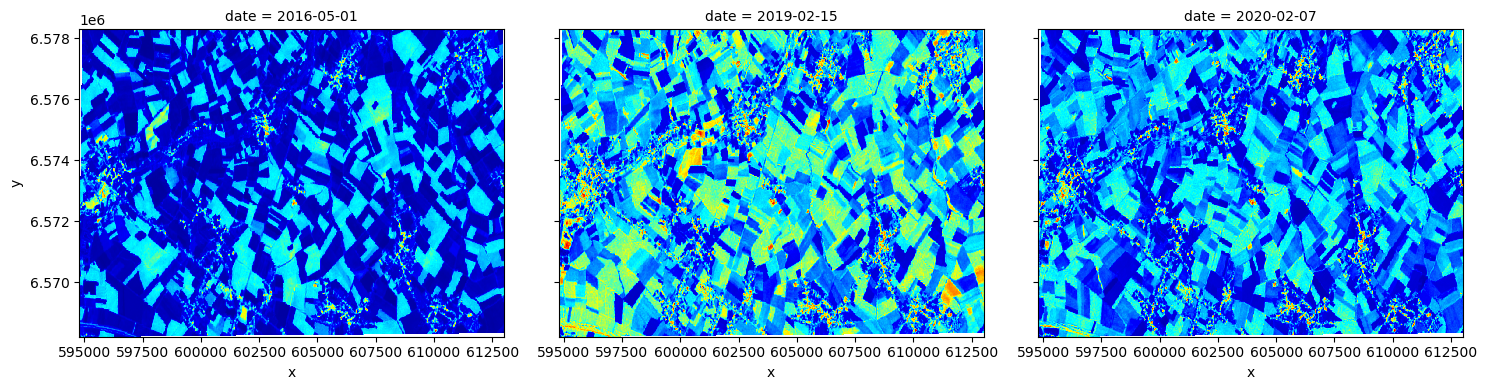

In [8]:
moisture_index.sortby("date").plot.imshow(col="date", figsize=(15, 4), aspect=1)

## Lazy load multiple files into a single `xarray.Dataset`

In the previous example, all data is read into memory. Xarray provides a separate function [`open_mfdataset`](http://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html#xarray-open-mfdataset) to read data lazy from disk (so not loading the data itself in memory) from multiple files. 

A usefule feature is the ability to preprocess the files:

> __preprocess (callable(), optional)__ – If provided, call this function on each dataset prior to concatenation. You can find the file-name from which each dataset was loaded in ds.encoding["source"].

Applied to the previous moisture index files example:

In [9]:
def add_date_dimension(ds):
    """Add the date dimension derived from the file_name and rename to moisture_index"""
    ds_date = pd.to_datetime(Path(ds.encoding["source"]).stem.split(",")[0])
    ds = ds.assign_coords(date=("date", [ds_date])).rename({"band_data": "moisture_index"})
    return ds

In [10]:
moisture_index_lazy = xr.open_mfdataset(sorted(Path("./data/herstappe/raster/sentinel_moisture").rglob("*.tiff")), 
                                        preprocess=add_date_dimension, engine="rasterio", decode_cf=False) # parallel=True
moisture_index_lazy["moisture_index"]

<xarray.DataArray 'moisture_index' (date: 3, band: 3, y: 1007, x: 1825)>
dask.array<concatenate, shape=(3, 3, 1007, 1825), dtype=uint16, chunksize=(1, 3, 1007, 1825), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 5.948e+05 5.948e+05 5.948e+05 ... 6.13e+05 6.13e+05
  * y            (y) float64 6.578e+06 6.578e+06 ... 6.568e+06 6.568e+06
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 2016-05-01 2019-02-15 2020-02-07
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

The data itself is not loaded directly and is divided into 3 chunks, i.e. a chunk for each date. See the notebook [15-xarray-dask-big-data](./15-xarray-dask-big-data.ipynb) notebook for more information on the processing of (out of memory) lazy data with Dask.

Further reading:

- See http://xarray.pydata.org/en/stable/user-guide/io.html#reading-multi-file-datasets for more examples.
- https://medium.com/@bonnefond.virginie/handling-multi-temporal-satellite-images-with-xarray-30d142d3391
- https://docs.dea.ga.gov.au/notebooks/Frequently_used_code/Opening_GeoTIFFs_NetCDFs.html#Loading-multiple-files-into-a-single-xarray.Dataset

## Save concatenated data to a single file

After processing multiple files, it is convenient to save the data in a preferred format afterwards. Convenient choices are [NetCDF](https://www.unidata.ucar.edu/software/netcdf/) and [Zarr](https://zarr.readthedocs.io/en/stable/). Zarr is a newer format providing some advantages when working in cloud environments, but can be used on a local machine as well.

In [11]:
moisture_index.to_netcdf("moisture_index_stacked.nc")

Hence, the next the data set can be loaded directly from disk:

In [12]:
xr.open_dataset("moisture_index_stacked.nc", engine="netcdf4")

<xarray.Dataset>
Dimensions:      (band: 3, x: 1825, y: 1007, date: 3)
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 5.948e+05 5.948e+05 5.948e+05 ... 6.13e+05 6.13e+05
  * y            (y) float64 6.578e+06 6.578e+06 ... 6.568e+06 6.568e+06
  * date         (date) datetime64[ns] 2016-05-01 2019-02-15 2020-02-07
Data variables:
    spatial_ref  int64 ...
    band_data    (date, band, y, x) float64 ...

Storing to zarr files works on the `xarray.DataSet` level:

In [13]:
moisture_index_lazy.to_zarr("moisture_index_stacked.zarr")

In [14]:
xr.open_dataset("moisture_index_stacked.zarr", engine="zarr")    

<xarray.Dataset>
Dimensions:         (band: 3, date: 3, y: 1007, x: 1825)
Coordinates:
  * band            (band) int64 1 2 3
  * date            (date) datetime64[ns] 2016-05-01 2019-02-15 2020-02-07
  * x               (x) float64 5.948e+05 5.948e+05 ... 6.13e+05 6.13e+05
  * y               (y) float64 6.578e+06 6.578e+06 ... 6.568e+06 6.568e+06
Data variables:
    moisture_index  (date, band, y, x) float64 ...
    spatial_ref     int64 ...

_clean up of these example files_

In [15]:
import shutil

if Path("moisture_index_stacked.zarr").exists():
    shutil.rmtree("moisture_index_stacked.zarr")
if Path("moisture_index_stacked.nc").exists():    
    Path("moisture_index_stacked.nc").unlink()

<div class="alert alert-success">

**EXERCISE**:
    
The [NOAA's NCEP Reanalysis data](https://psl.noaa.gov/data/gridded/data.ncep.reanalysis.html) files are stored on a remote server and can be accessed over OpenDAP.
    
> The NCEP/NCAR Reanalysis data set is a continually updated (1948–present) globally gridded data set that represents the state of the Earth's atmosphere, incorporating observations and numerical weather prediction (NWP) model output from 1948 to present.
    
An example can be found in NCEP Reanalysis catalog:

https://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/ncep.reanalysis/surface/catalog.html

The dataset is split into different files for each variable and year. For example, a single file download link for surface air temperature looks like:

https://psl.noaa.gov/thredds/fileServer/Datasets/ncep.reanalysis/surface/air.sig995.1948.nc   
    
The structure is `'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.`' + `'YYYY'` + `'.nc'`
    
We want to download the surface temperature data from 1990 till 2000 and combine them all in a single xarray DataSet. To do so:
    
- Prepare all the links by composing the base_url ('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995') with the required years
- Use the list of file links as the inputfor the `xr.open_mfdataset` to create a single `xarray.DataSet`.
- Whereas this is 600MB of data, the initial loading is not actually reading in the data.
   
<details>
    
<summary>Hints</summary>

* Python works with string formatting, e.g. f'{base_url}.{year}.nc' will nicely create the required links.
* Xarray can both work with file names on a computer as a compatible network link.
* As the netcdf data provided by NOAA is already well structured and confomr, no further adjustments are required as input to the 
`open_mfdataset` function, :-)

</details>    
    
</div>

In [16]:
base_url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995'

files = [f'{base_url}.{year}.nc' for year in range(1990, 2001)]
files

['http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1990.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1991.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1992.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1993.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1994.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1995.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1996.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1997.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1998.nc',
 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1999.nc',
 'http://w

In [17]:
ds = xr.open_mfdataset(files, parallel=True)
ds

<xarray.Dataset>
Dimensions:  (lon: 144, time: 16072, lat: 73)
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1990-01-01 ... 2000-12-31T18:00:00
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
Data variables:
    air      (time, lat, lon) float32 dask.array<chunksize=(1460, 73, 144), meta=np.ndarray>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    history:                         /home/hoop/crdc/cpreanjuke2farm/cpreanju...
    dataset_title:                   NCEP-NCAR Reanalysis 1
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    DODS_EXTRA.Unlimited_Dimension:  time

## (Optional) Online data Catalogs: STAC

__Note__ _These dependencies are not included in the environment, to run this section, install the required packages first in your conda environment: `conda install stackstac pystac-client`._

Multiple initiatives do exist which publish data online which enables (lazy) loading of the data directly in xarray, such as [OpenDAP](https://www.opendap.org/) and [THREDDS](https://www.unidata.ucar.edu/software/tds/current/) which are well-known and used in the oceanographic and climate studies communities (see exercise). See for example the [ROMS Ocean Model Example](http://xarray.pydata.org/en/stable/examples/ROMS_ocean_model.html) tutorial of xarray. 

Another initiative that interacts well with xarray is the [SpatioTemporal Asset Catalogs](https://stacspec.org/) specification, which is increasingly used to publish remote sensing products.

In [18]:
import stackstac
import pystac_client

In [19]:
lon, lat = -105.78, 35.79

In [20]:
URL = "https://earth-search.aws.element84.com/v0"
catalog = pystac_client.Client.open(URL)

In [21]:
results = catalog.search(
    intersects=dict(type="Point", coordinates=[lon, lat]),
    collections=["sentinel-s2-l2a-cogs"],
    datetime="2020-04-01/2020-05-01"
)
results.matched()

13

In [22]:
list(results.items())[0]

ID: S2B_13SDV_20200501_0_L2A
"Bounding Box: [-106.11191385205835, 35.1499211736146, -105.53016102054627, 36.14371597420606]"
Datetime: 2020-05-01 18:04:03+00:00
datetime: 2020-05-01T18:04:03Z
platform: sentinel-2b
constellation: sentinel-2
instruments: ['msi']
gsd: 10
data_coverage: 34.29
view:off_nadir: 0
eo:cloud_cover: 5.41


In [23]:
results.item_collection()

ID: S2B_13SDV_20200501_0_L2A
"Bounding Box: [-106.11191385205835, 35.1499211736146, -105.53016102054627, 36.14371597420606]"
Datetime: 2020-05-01 18:04:03+00:00
datetime: 2020-05-01T18:04:03Z
platform: sentinel-2b
constellation: sentinel-2
instruments: ['msi']
gsd: 10
data_coverage: 34.29
view:off_nadir: 0
eo:cloud_cover: 5.41


In [24]:
stacked = stackstac.stack(results.item_collection())

In [25]:
stacked

<xarray.DataArray 'stackstac-bd31017ff28530a17ccd6ce6e9b4994f' (time: 13,
                                                                band: 17,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<fetch_raster_window, shape=(13, 17, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/24)
  * time                        (time) datetime64[ns] 2020-04-01T18:04:04 ......
    id                          (time) <U24 'S2B_13SDV_20200401_0_L2A' ... 'S...
  * band                        (band) <U8 'overview' 'B11' ... 'visual' 'SCL'
  * x                           (x) float64 4e+05 4e+05 ... 5.097e+05 5.098e+05
  * y                           (y) float64 4e+06 4e+06 ... 3.89e+06 3.89e+06
    sentinel:utm_zone           int64 13
    ...                          ...
    view:off_nadir              int64 0
    sentinel:latitude_band      <U1 'S'
    data_coverage               (time) object 33.85 100 33.9 ... 32.84 100 34.29
    updated                     (time) <U24 '2020-09-05T06:23:47.836Z' ... '2...
    title                       (band) <U31 'True color image' ... 'Scene Cla...
    epsg                        int64 32613
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(399960.0, 3890220.0, 509760.0...
    crs:         epsg:32613
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 4000020.00|\n| 0.0...
    resolution:  10.0

See also https://github.com/stac-utils/pystac-client and https://stackstac.readthedocs.io/en/latest/.

__Acknowledgements__ Thanks to [@rabernat](https://rabernat.github.io/research_computing_2018/xarray-tips-and-tricks.html) for the example case of NCEP reanalysis data load and https://stackstac.readthedocs.io/en/latest/basic.html#Basic-example for the stackteac example.